In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Data Encoding and Scaling
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, RobustScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [3]:
warnings.filterwarnings('ignore')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
df = pd.read_csv('experiment_data1.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4461 entries, 0 to 4460
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   jobma_catcher_id                4461 non-null   int64  
 1   is_premium                      4461 non-null   int64  
 2   subscription_status             4461 non-null   int64  
 3   company_size                    4461 non-null   object 
 4   total_sub                       4461 non-null   int64  
 5   is_unlimited                    4461 non-null   int64  
 6   subscription_amount_in_dollars  4461 non-null   float64
 7   number_of_subscriptions         4461 non-null   int64  
 8   number_of_invitations           4461 non-null   int64  
 9   job_posted                      4461 non-null   int64  
 10  number_of_kits                  4461 non-null   int64  
 11  number_of_recorded_interviews   4461 non-null   int64  
 12  number_of_live_interviews       44

# Data Encoding

In [8]:
def ordinal_encoder(df):
    # Define the ordinal column and the ordering
    ordinal_col = ['company_size', 'days_since_last_login']
    company_size_order = ['1-25', '26-100', '101-500', '500-1000', 'More than 1000']
    login_days_order = ['Less than 1 Week', '1-4 Weeks', '1-3 Months', '3-6 Months', '6-12 Months', 'More than 1 Year']

    total_order = [company_size_order, login_days_order]
    # Initialize OrdinalEncoder with specified categories
    ordinal = OrdinalEncoder(categories=total_order)
    
    # Fit and transform the data (make sure input is 2D for encoding)
    encoded = ordinal.fit_transform(df[ordinal_col].astype(str))

    # Shift encoding to start from 1
    encoded += 1
    
    # Convert the encoded result to a DataFrame with the appropriate column name
    encoded_df = pd.DataFrame(encoded, columns=[f'{col}_ord' for col in ordinal_col], index=df.index)

    # Drop the original column
    df.drop(columns=ordinal_col, inplace=True)

    # Concatenate the encoded column to the original dataframe
    df = pd.concat([df, encoded_df], axis=1)
    
    return df

# Log Transformation

In [10]:
log_cols = [
    'total_sub',
    'subscription_amount_in_dollars',
    'number_of_subscriptions'
    'number_of_invitations',
    'job_posted',
    'number_of_kits',
    'number_of_recorded_interviews',
    'number_of_live_interviews',
    'days_since_last_login'
]

In [11]:
def log_transform(df):
    df = df.copy()
    for col in log_cols:
        if col in df.columns:
            # fill NaNs
            df[col] = df[col].fillna(0)
            # if a number is less than zero, turn it into zero;
            df[col] = df[col].clip(lower=0)
            # safe log1p
            df[col] = np.log1p(df[col])
            
    return df

# Pipeline

In [13]:
pipeline = Pipeline([
    # ('fill_missing_values', FunctionTransformer(fill_missing_values, validate=False)),
    ('ordinal_encoder', FunctionTransformer(ordinal_encoder, validate=False)),
    # ('one_hot_encoder', CustomOneHotEncoder(columns=['is_premium', 'subscription_status', 'is_unlimited'])),
    # ('one_hot_encoder', FunctionTransformer(one_hot_encoder, validate=False)),
    ('log_transformation', FunctionTransformer(log_transform, validate=False)), # log transforms the col with outliers
    ('scaler', StandardScaler()), # Needs attention to improve model
])

In [14]:
set_config(display='diagram')
pipeline

Pipeline(steps=[('ordinal_encoder',
                 FunctionTransformer(func=<function ordinal_encoder at 0x0000021194F0AD40>)),
                ('log_transformation',
                 FunctionTransformer(func=<function log_transform at 0x0000021194F5C5E0>)),
                ('scaler', StandardScaler())])

# Fit Pipeline

In [16]:
X = df

In [17]:
X_transformed = pipeline.fit_transform(X)

In [18]:
features_names = df.columns

In [19]:
X_df = pd.DataFrame(X_transformed)

In [20]:
X_df.columns

RangeIndex(start=0, stop=14, step=1)

In [21]:
X_tensor = torch.tensor(X_transformed, dtype=torch.float32).to(device)

# Dataset

In [23]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [24]:
X_data = CustomDataset(X_tensor)

# DataLoader

In [26]:
dataloader = DataLoader(X_data, batch_size=16, shuffle=False)

# AutoEncoder

In [28]:
class AutoEncoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)  # bottleneck
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_shape)
        )

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [29]:
''' Initializing the model '''
input_shape = X_df.shape[1]

model_1 = AutoEncoder(input_shape)
model_1.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=14, bias=True)
  )
)

In [30]:
''' Important Parameters '''
learning_rate = 0.001
epochs = 50
patience = 5
delta = 1e-4

best_loss = float('inf')
epochs_no_improve = 0
training_losses = []

In [31]:
''' Loss Function and Optimizers '''

# mse_loss_function = nn.MSELoss()
loss_function = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model_1.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Training Loop

In [33]:
for epoch in range(epochs):
    model_1.train()
    epoch_loss = 0

    for batch in dataloader:
        encoded, decoded = model_1(batch)
        loss = loss_function(decoded, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    training_losses.append(avg_loss)
    scheduler.step(avg_loss)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")

    # Early stopping
    if avg_loss < best_loss - delta:
        best_loss = avg_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Print current learning rate
    for param_group in optimizer.param_groups:
        print(f"Learning Rate: {param_group['lr']:.6f}")

Epoch 1/50 | Loss: 0.176697
Learning Rate: 0.001000
Epoch 2/50 | Loss: 0.129937
Learning Rate: 0.001000
Epoch 3/50 | Loss: 0.110081
Learning Rate: 0.001000
Epoch 4/50 | Loss: 0.094731
Learning Rate: 0.001000
Epoch 5/50 | Loss: 0.084248
Learning Rate: 0.001000
Epoch 6/50 | Loss: 0.078944
Learning Rate: 0.001000
Epoch 7/50 | Loss: 0.072337
Learning Rate: 0.001000
Epoch 8/50 | Loss: 0.065944
Learning Rate: 0.001000
Epoch 9/50 | Loss: 0.058045
Learning Rate: 0.001000
Epoch 10/50 | Loss: 0.057528
Learning Rate: 0.001000
Epoch 11/50 | Loss: 0.054732
Learning Rate: 0.001000
Epoch 12/50 | Loss: 0.052194
Learning Rate: 0.001000
Epoch 13/50 | Loss: 0.051575
Learning Rate: 0.001000
Epoch 14/50 | Loss: 0.048478
Learning Rate: 0.001000
Epoch 15/50 | Loss: 0.049808
Learning Rate: 0.001000
Epoch 16/50 | Loss: 0.047653
Learning Rate: 0.001000
Epoch 17/50 | Loss: 0.043147
Learning Rate: 0.001000
Epoch 18/50 | Loss: 0.042424
Learning Rate: 0.001000
Epoch 19/50 | Loss: 0.042123
Learning Rate: 0.001000
Ep

# Clustering

In [35]:
model_1.eval()

with torch.no_grad():
    encoder, _ = model_1(X_tensor)

latent_np = encoder.cpu().numpy()

In [36]:
wcss = []
silhouette_scores = []
k_range = range(2,11)

In [37]:
torch.manual_seed(42)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(latent_np)
    
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    silhouette_scores.append(silhouette_score(latent_np, labels))

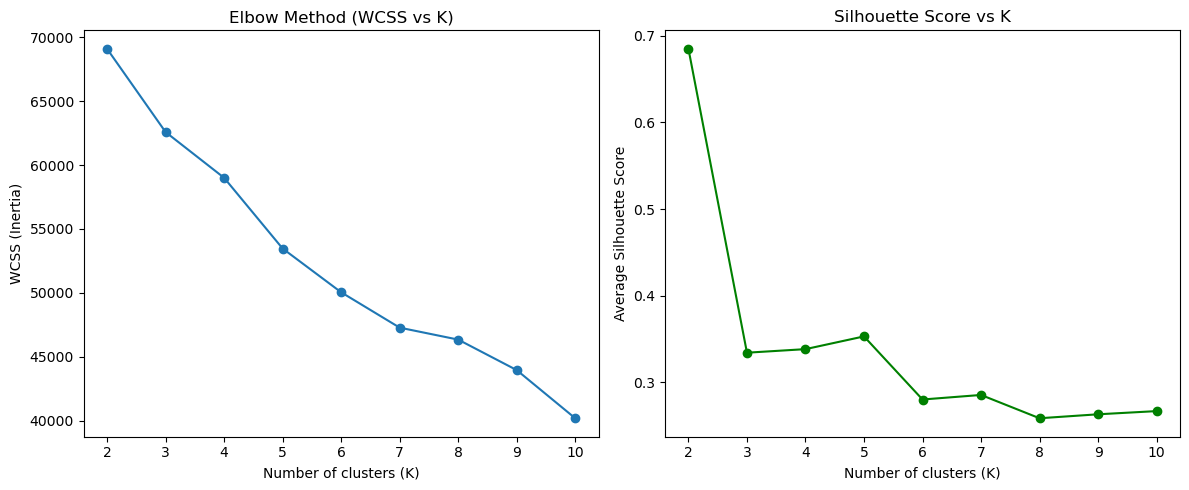

In [38]:
''' Elbow Rule to decide the number of clusters '''
torch.manual_seed(42)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method (WCSS vs K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Inertia)')

# Step 5: Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Average Silhouette Score')

plt.tight_layout()
plt.show()

In [39]:
#Initialising KMeans
kmeans = KMeans(n_clusters=4, n_init=50, init='k-means++', random_state=42)
cluster_ids = kmeans.fit_predict(latent_np)
cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

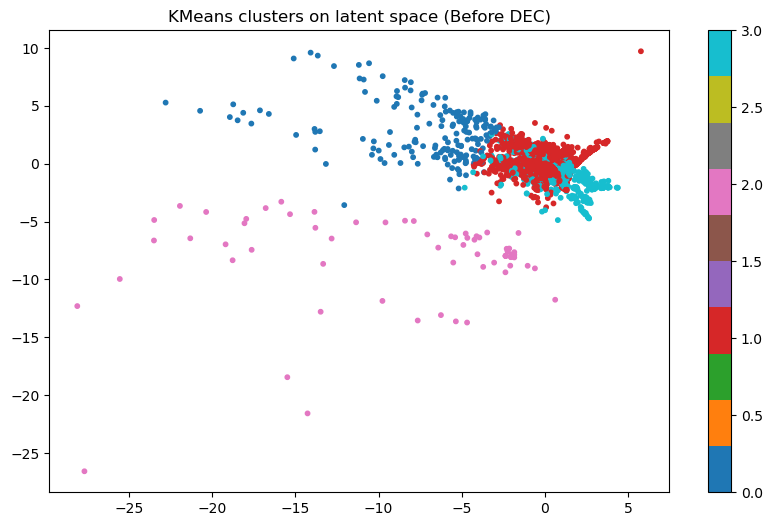

In [40]:
latent_2d = PCA(n_components=2).fit_transform(latent_np)
plt.figure(figsize=(10, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=cluster_ids, cmap='tab10', s=10)
plt.title("KMeans clusters on latent space (Before DEC)")
plt.colorbar()
plt.show()

# DEC

In [42]:
# Deep Embedding Clusturing Model
class DEC(nn.Module):
    def __init__(self, encoder, cluster_centers):
        super(DEC, self).__init__()
        self.encoder = encoder
        self.cluster_centers = nn.Parameter(cluster_centers)

    def forward(self, x):
        z = self.encoder(x)
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.cluster_centers)**2, dim=2))
        q = q.pow((1 + 1) / 2.0)
        q = (q.t() / torch.sum(q, dim=1)).t()
        return q, z

def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()  

In [43]:
''' Initializing DEC Model '''
dec = DEC(model_1.encoder, cluster_centers.clone()).to(device)

In [44]:
''' Loss Function and Optimizer '''

kl_loss = nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.Adam(dec.parameters(), lr=5e-4)
batch_size = dataloader.batch_size

In [45]:
dec.train()
num_epochs = 50
for epoch in range(num_epochs):
    # Compute global soft assignments q_all
    with torch.no_grad():
        q_all, _ = dec(X_tensor.to(device))            
        p_all = target_distribution(q_all)              

    epoch_loss = 0.0
    for batch_idx, batch in enumerate(dataloader):
        x = batch.to(device)
        q_batch, _ = dec(x)                            

        # Slice the matching rows from p_all
        start = batch_idx * batch_size
        end   = start + x.size(0)
        p_batch = p_all[start:end].to(device)          

        # Compute loss against the global target
        loss = kl_loss(torch.log(q_batch + 1e-8), p_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x.size(0)

    avg_loss = epoch_loss / len(X_tensor)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg KL Loss: {avg_loss:.4f}")

Epoch 1/50, Avg KL Loss: 0.0592
Epoch 2/50, Avg KL Loss: 0.0818
Epoch 3/50, Avg KL Loss: 0.0962
Epoch 4/50, Avg KL Loss: 0.1091
Epoch 5/50, Avg KL Loss: 0.1032
Epoch 6/50, Avg KL Loss: 0.0995
Epoch 7/50, Avg KL Loss: 0.0982
Epoch 8/50, Avg KL Loss: 0.0962
Epoch 9/50, Avg KL Loss: 0.0938
Epoch 10/50, Avg KL Loss: 0.0936
Epoch 11/50, Avg KL Loss: 0.0908
Epoch 12/50, Avg KL Loss: 0.0928
Epoch 13/50, Avg KL Loss: 0.0858
Epoch 14/50, Avg KL Loss: 0.0845
Epoch 15/50, Avg KL Loss: 0.0813
Epoch 16/50, Avg KL Loss: 0.0792
Epoch 17/50, Avg KL Loss: 0.0829
Epoch 18/50, Avg KL Loss: 0.0787
Epoch 19/50, Avg KL Loss: 0.0760
Epoch 20/50, Avg KL Loss: 0.0776
Epoch 21/50, Avg KL Loss: 0.0740
Epoch 22/50, Avg KL Loss: 0.0717
Epoch 23/50, Avg KL Loss: 0.0654
Epoch 24/50, Avg KL Loss: 0.0640
Epoch 25/50, Avg KL Loss: 0.0629
Epoch 26/50, Avg KL Loss: 0.0607
Epoch 27/50, Avg KL Loss: 0.0583
Epoch 28/50, Avg KL Loss: 0.0581
Epoch 29/50, Avg KL Loss: 0.0650
Epoch 30/50, Avg KL Loss: 0.0576
Epoch 31/50, Avg KL

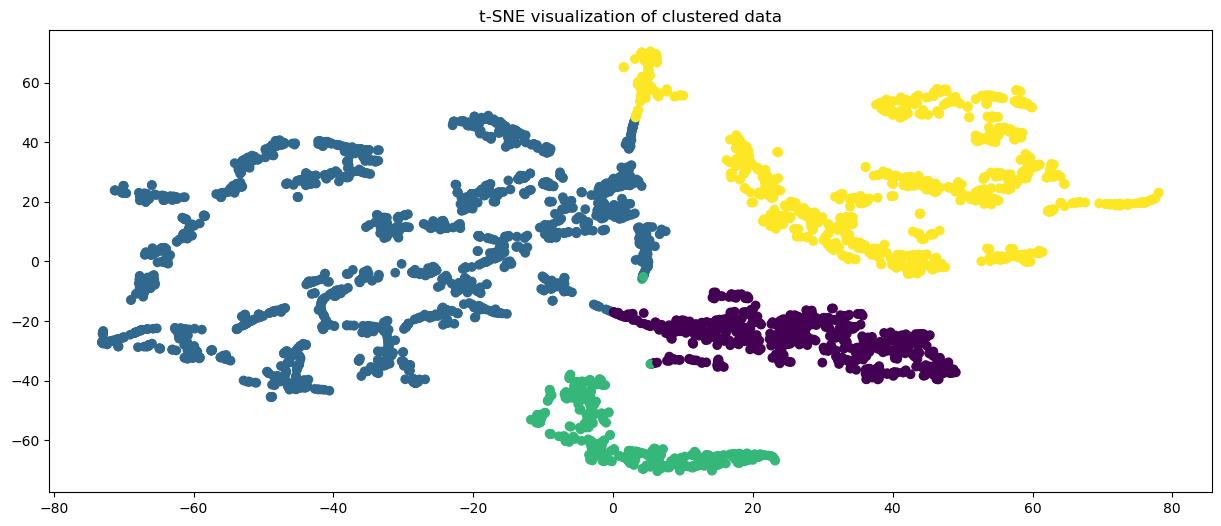

In [46]:
''' Visualizing the Clusters '''

dec.eval()

with torch.no_grad():
    q, _ = dec(X_tensor.to(device))  # Get cluster assignments
    preds = torch.argmax(q, dim=1).cpu().numpy()

with torch.no_grad():
    _, z= dec(X_tensor.to(device)) # Get embedded features
    # Reduce dimensions for visualization (using t-SNE)
    z_2d = TSNE(n_components=2).fit_transform(z.cpu().numpy())

    # Visualize the clusters (color = cluster assignments)
    plt.figure(figsize=(15,6))
    plt.scatter(z_2d[:,0], z_2d[:,1], c=preds, cmap='viridis')
    plt.title('t-SNE visualization of clustered data')
    plt.show()

In [47]:
''' Add cluster labels to original dataframe '''
df_train = df.iloc[-X_tensor.shape[0]:].copy()
df_train['cluster_id'] = preds

In [48]:
# ''' Add cluster labels to original dataframe '''
# df_train = X_df.iloc[-X_tensor.shape[0]:].copy()
# df_train['cluster_id'] = preds

In [49]:
cluster_summary = df_train.groupby('cluster_id').mean(numeric_only=True)
cluster_summary

,jobma_catcher_id,is_premium,subscription_status,total_sub,is_unlimited,subscription_amount_in_dollars,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits,number_of_recorded_interviews,number_of_live_interviews
cluster_id,,,,,,,,,,,,
0,6890.494876,0.333821,0.708638,1.048316,0.093704,2996.070533,2.440703,33.478770,5.049780,5.459736,14.163982,0.058565
1,6687.860927,0.106906,0.752602,0.113056,0.000000,9474.645873,1.667455,0.129139,0.061022,0.099811,0.031220,0.000000
2,5941.046948,0.809859,0.563380,1.037559,0.053991,5402.699400,5.384977,137.683099,1.981221,2.678404,8.892019,0.772300
3,5940.970113,0.145396,0.840872,0.199515,0.676090,196398.812756,1.573506,0.181745,0.117932,0.124394,0.048465,0.000000


In [50]:
unique_clusters = np.unique(preds)
print(f"Unique Clusters Found: {len(unique_clusters)} -> {unique_clusters}")

Unique Clusters Found: 4 -> [0 1 2 3]


# Final Step: Add Meaningful Cluster Labels for Recommendation System

In [52]:
cluster_names = {
    0: "Loyal",   # Average
    1: "Engaged",   # Active
    2: "Dormant",   # Very Low Activity
    3: "Passive"
}
df_train['cluster_label'] = df_train['cluster_id'].map(cluster_names)

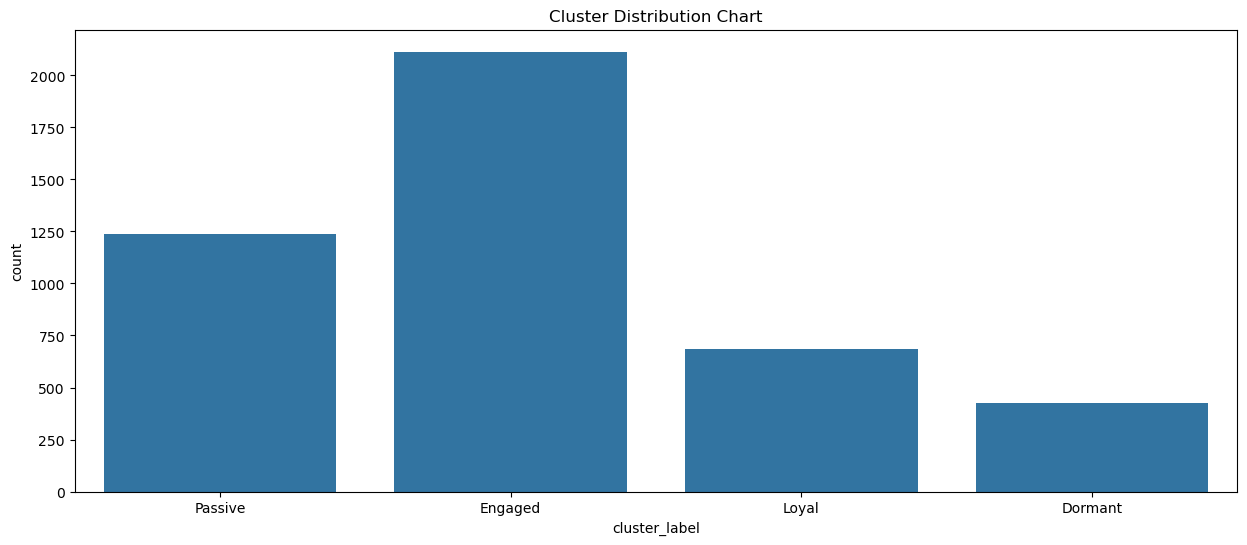

In [53]:
''' Visualizing the Cluster as a chart to determine the distribution of labels '''

plt.figure(figsize=(15,6))
sns.countplot(x='cluster_label', data=df_train)
plt.title('Cluster Distribution Chart')
plt.show()

# Recommendation System

In [55]:
original_df = pd.read_csv('experiment_data1.csv')

In [56]:
# def recommend(df, original_df, metric='subscription_amount_in_dollars', top_k=5, label='Loyal'):
#     loyal_df = df[df['cluster_label'] == label]
#     top_clients_df = loyal_df.sort_values(by=metric, ascending=False).head(top_k)
#     merged_df = pd.merge(top_clients_df,
#                          original_df[['jobma_catcher_id', 'company_size', 'is_premium']], 
#                          on='jobma_catcher_id', 
#                          how='left', 
#                          suffixes=('_train', '_orig'))

#     # columns_to_return = [col for col in ['jobma_catcher_id', 'jobma_catcher_company', 'company_size', 'is_premium'] if col in merged_df.columns]
    
#     return merged_df[[
#         'jobma_catcher_id',
#         'company_size_orig',
#         'is_premium_orig'
#     ]].rename(columns={
#         'company_size_orig': 'company_size',
#         'is_premium_orig'  : 'is_premium'
#     })

In [57]:
original_df.columns

Index(['jobma_catcher_id', 'is_premium', 'subscription_status', 'company_size',
       'total_sub', 'is_unlimited', 'subscription_amount_in_dollars',
       'number_of_subscriptions', 'number_of_invitations', 'job_posted',
       'number_of_kits', 'number_of_recorded_interviews',
       'number_of_live_interviews', 'days_since_last_login'],
      dtype='object')

In [58]:
df.columns

Index(['jobma_catcher_id', 'is_premium', 'subscription_status', 'total_sub',
       'is_unlimited', 'subscription_amount_in_dollars',
       'number_of_subscriptions', 'number_of_invitations', 'job_posted',
       'number_of_kits', 'number_of_recorded_interviews',
       'number_of_live_interviews'],
      dtype='object')

In [59]:
def recommend(df, original_df, metric='subscription_amount_in_dollars', top_k=5, label='Loyal'):     
    loyal_df = df[df['cluster_label'] == label]     
    top_clients_df = loyal_df.sort_values(by=metric, ascending=False).head(top_k)     
    return top_clients_df

In [60]:
# def recommend(df, original_df, metric='subscription_amount_in_dollars', top_k=5, label='Loyal'):     
#     loyal_df = df[df['cluster_label'] == label]     
#     top_clients_df = loyal_df.sort_values(by=metric, ascending=False).head(top_k) 
#     merged_df = pd.merge(original_df, top_clients_df, on='jobma_catcher_id', how='inner')
#     return merged_df

In [61]:
''' Loyal '''

result_loyal = recommend(df_train, original_df, metric='subscription_amount_in_dollars', top_k=10, label='Loyal')
result_loyal

,jobma_catcher_id,is_premium,subscription_status,total_sub,is_unlimited,subscription_amount_in_dollars,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits,number_of_recorded_interviews,number_of_live_interviews,cluster_id,cluster_label
2561,6909,1,0,1,0,362492.080253,10,4,1,1,1,0,0,Loyal
507,3678,1,1,13,0,207889.465916,33,485,92,27,215,18,0,Loyal
1995,6081,0,0,2,1,70011.732958,8,50,1,1,26,0,0,Loyal
3754,8732,0,0,0,0,45200.000000,12,2,0,3,2,0,0,Loyal
3972,9757,1,0,11,1,40850.000000,13,102,12,7,47,0,0,Loyal
3312,7834,0,1,0,1,40000.000000,4,3,2,1,3,0,0,Loyal
3003,7464,1,1,3,0,37400.000000,27,84,8,42,27,0,0,Loyal
1863,5834,0,1,0,1,35000.000000,2,2,2,2,1,0,0,Loyal
961,4401,1,1,1,0,34615.133169,4,0,1,1,0,0,0,Loyal
540,3724,0,1,1,0,34612.225742,1,16,4,1,9,0,0,Loyal


In [62]:
''' Dormant '''

result_dormant = recommend(df_train, original_df, metric='subscription_amount_in_dollars', top_k=10, label='Dormant')
result_dormant

,jobma_catcher_id,is_premium,subscription_status,total_sub,is_unlimited,subscription_amount_in_dollars,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits,number_of_recorded_interviews,number_of_live_interviews,cluster_id,cluster_label
3309,7831,0,1,1,1,270050.000000,25,0,0,0,0,0,2,Dormant
2705,7097,0,0,1,1,164000.000000,20,0,0,0,0,0,2,Dormant
393,3502,1,1,1,0,138717.010090,25,6,1,1,1,0,2,Dormant
1234,4809,1,0,0,0,117351.195588,8,0,0,0,0,0,2,Dormant
1813,5761,0,1,1,1,113319.000000,29,0,0,0,0,0,2,Dormant
3748,8636,1,0,1,0,74050.000000,58,0,0,0,0,0,2,Dormant
675,3925,1,0,1,0,69286.225507,23,0,0,0,0,0,2,Dormant
3625,8376,1,1,1,0,60551.000000,46,5,2,2,3,0,2,Dormant
4042,9863,1,0,5,0,51600.000000,19,312,34,60,188,1,2,Dormant
3965,9745,1,0,3,1,41150.000000,16,4,1,3,0,1,2,Dormant


In [112]:
''' Engaged '''

result_engaged = recommend(df_train, original_df, metric='subscription_amount_in_dollars', top_k=10, label='Engaged')
result_engaged

,jobma_catcher_id,is_premium,subscription_status,total_sub,is_unlimited,subscription_amount_in_dollars,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits,number_of_recorded_interviews,number_of_live_interviews,cluster_id,cluster_label
2706,7098,1,1,0,0,1.393573e+07,3,0,0,0,0,0,1,Engaged
1225,4799,0,0,1,0,3.021390e+06,8,0,0,0,0,0,1,Engaged
2918,7362,0,1,0,0,6.000000e+05,3,0,0,0,0,0,1,Engaged
730,4002,0,1,0,0,1.384531e+05,7,0,0,0,0,0,1,Engaged
2793,7198,0,0,0,0,4.005000e+04,5,0,0,0,0,0,1,Engaged
1277,4854,0,1,0,0,3.476575e+04,5,0,0,0,0,0,1,Engaged
810,4142,0,1,0,0,3.475067e+04,2,0,0,0,0,0,1,Engaged
677,3928,1,1,0,0,3.465270e+04,3,0,0,0,0,0,1,Engaged
465,3628,1,1,0,0,3.462607e+04,2,0,0,0,0,0,1,Engaged
593,3806,1,1,0,0,3.462261e+04,2,0,0,0,0,0,1,Engaged


In [114]:
''' Passive '''

result_passive = recommend(df_train, original_df, metric='subscription_amount_in_dollars', top_k=10, label='Passive')
result_passive

,jobma_catcher_id,is_premium,subscription_status,total_sub,is_unlimited,subscription_amount_in_dollars,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits,number_of_recorded_interviews,number_of_live_interviews,cluster_id,cluster_label
2610,6964,0,0,1,1,1.188726e+08,19,0,0,0,0,0,3,Passive
2615,6970,0,1,0,1,1.188500e+08,5,0,0,0,0,0,3,Passive
2882,7319,0,0,1,1,2.000000e+05,4,0,0,0,0,0,3,Passive
3004,7465,0,1,1,1,1.712500e+05,16,0,0,0,0,0,3,Passive
3417,7973,0,0,0,1,1.400000e+05,2,0,0,0,0,0,3,Passive
2349,6631,0,0,1,1,1.300000e+05,13,0,0,0,0,0,3,Passive
2632,7002,0,0,0,1,1.300000e+05,2,0,0,0,0,0,3,Passive
1825,5779,0,1,0,1,1.200000e+05,4,0,0,0,0,0,3,Passive
1298,4878,0,1,0,1,1.000000e+05,1,0,0,0,0,0,3,Passive
1300,4880,0,1,0,1,1.000000e+05,1,0,0,0,0,0,3,Passive
